In [1]:
import gym
import torch
import torch.nn.functional as F
from scipy.special import softmax
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils
import GridWorld_v5
import draw

import utils

In [2]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, env_row, env_column, learning_rate, gamma):
        self.action_dim = action_dim
        self.state_dim =state_dim

        self.env_row = env_row
        self.env_column = env_column
        
        self.weight_tabular = np.full((env_row * env_column, action_dim), 1/action_dim)  #权重矩阵，输出得套softmax层
        self.learning_rate = learning_rate
        
        self.gamma = gamma  # 折扣因子
        self.epsilon = 1

    def take_action(self, state):  # 根据动作概率分布随机采样 #state都是（x，y）的
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            x, y = state[0], state[1]
            now_frame_probabilities  = softmax(self.weight_tabular[x *self.env_column + y])
            action = np.random.choice(self.action_dim, p=now_frame_probabilities)
            return action

    def getProbabilities(self):
        # 返回一个维度是state*action的概率矩阵，每一行相加和为1
        softmax_scores = softmax(self.weight_tabular, axis=-1)  # 默认对最后一个维度进行求softmax
        # softmax_scores = softmax(self.weight_tabular)  # 默认对最后一个维度进行求softmax
        return softmax_scores
    
    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        losses = [[[]for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)]
        tmp = None
        for i in reversed(range(len(reward_list))):  # 从最后一步算起

            reward = reward_list[i]
            state = state_list[i]
            x,y = state[0],state[1]
            action = action_list[i]
            
            G = self.gamma * G + reward

            softmax_list = softmax(self.weight_tabular[x * self.env_column + y])

            for k in range(self.action_dim):
                if action == k: 
                    grad = softmax_list[action] * (1 - softmax_list[action])
                else:
                    grad = -softmax_list[action] * softmax_list[k]
                    
                loss = grad * G  # 每一步的损失函数 注意这里还没加减号
                losses[x*self.env_column+y][k].append(loss)
            
        #求个平均，免得一次更新那么多，梯度爆炸
        loss_mean = np.array([[sum(losses[i][j]) / len(losses[i][j] ) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss_sum = np.array([[sum(losses[i][j]) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss = loss_sum
        
        self.loss = loss
        
        self.weight_tabular += loss * self.learning_rate #梯度上升，为了提升总奖励


In [3]:
def train(hyperparameters, img_path):
    rows = 5      #记得行数和列数这里要同步改
    columns = 5
    
    forbiddenAreaScore = hyperparameters['forbiddenAreaScore']
    targetAreaScore = hyperparameters['targetAreaScore']
    hitWallScore = hyperparameters['hitWallScore']
    moveScore = hyperparameters['moveScore']
    start_state = hyperparameters['start_state']
    action_space = hyperparameters['action_space']
    learning_rate = hyperparameters['learning_rate']
    num_episodes = hyperparameters['num_episodes']
    hidden_dim = hyperparameters['hidden_dim']
    gamma = hyperparameters['gamma']
    
    env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
                                    desc = [".....",".##..","..#..",".#T#.",".#..."]) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#..T",
    #                                         ".....#."]) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#...",
    #                                         ".....#T"]) 
    
    agent = REINFORCE(state_dim = env.get_observation_space(), 
              hidden_dim = hidden_dim, 
              action_dim = env.get_action_space(), 
              env_row = env.rows, 
              env_column = env.columns, 
              learning_rate = learning_rate, 
              gamma = gamma)

    return_list = []

    epsilon = hyperparameters['begin_epsilon']
    final_epsilon = hyperparameters['final_epsilon']
    for i in tqdm(range(num_episodes)):# 10000
        if(epsilon > final_epsilon) :
            epsilon -= hyperparameters['gamma_minus_each_episodes']
        else:
            epsilon = final_epsilon
        agent.epsilon = epsilon

        episode_return = 0
        transition_dict = {
            'states': [],
            'actions': [],
            'next_states': [],
            'rewards': [],
            'dones': []
        }
        state = env.reset()
        done = False
        cnt = 0
        while not done:
            cnt = cnt + 1
            action = agent.take_action(state) ########
            next_state, reward, done, _ = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
            if cnt>hyperparameters['exploring_step']:
                break
            
        return_list.append(episode_return)
        pre_frame_probabilities = agent.getProbabilities()
        agent.update(transition_dict)
        now_frame_probabilities = agent.getProbabilities()
        
        if i % 20000 == 0:
            # print(pre_frame_probabilities)
            # print(now_frame_probabilities)
            draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.loss , transition_dict['states'], env.get_map_description(), img_path+f"epi-{i}")

experiments/Penalty-200_Score50_State(0~24)/Penalty-200_Score50_State10


  0%|                                                                                  | 0/100000 [00:00<?, ?it/s]findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


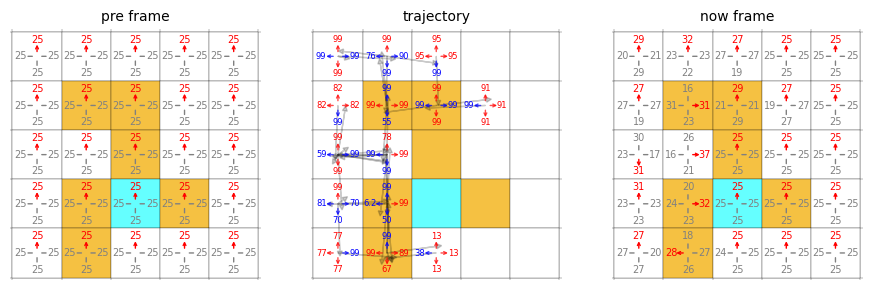

 20%|█████████████▊                                                       | 19931/100000 [00:24<01:24, 943.14it/s]

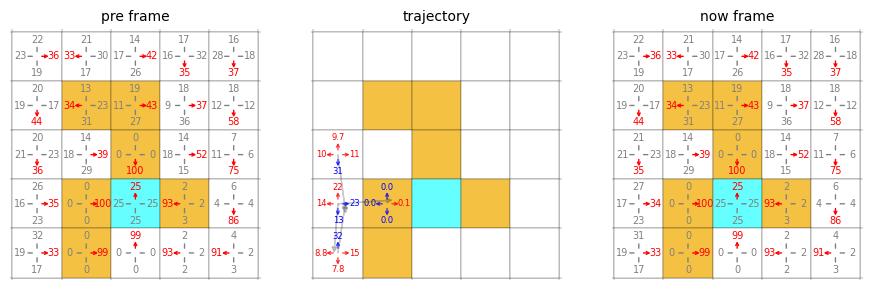

 40%|███████████████████████████▌                                         | 39991/100000 [00:57<01:38, 607.77it/s]

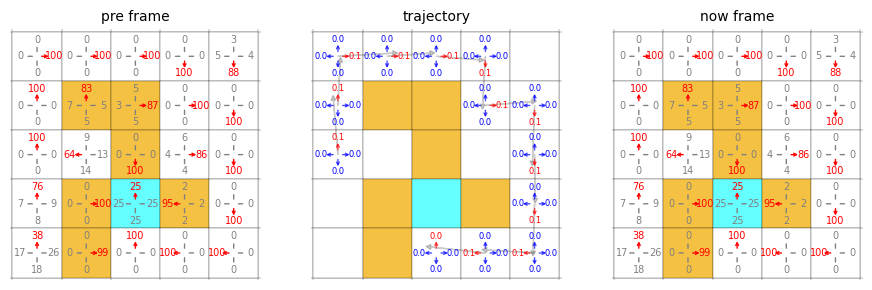

 60%|█████████████████████████████████████████▎                           | 59960/100000 [01:34<01:07, 593.23it/s]

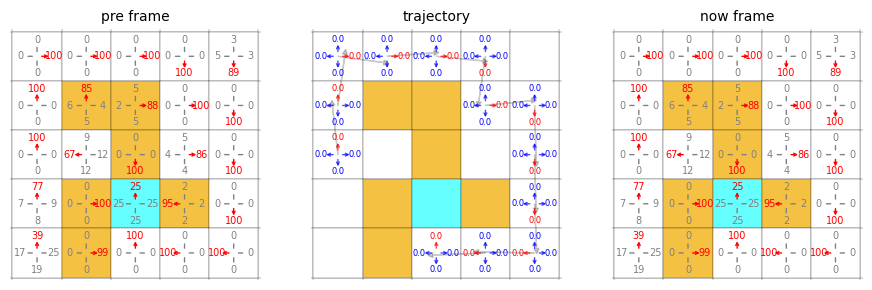

 80%|███████████████████████████████████████████████████████▏             | 79951/100000 [02:11<00:32, 621.99it/s]

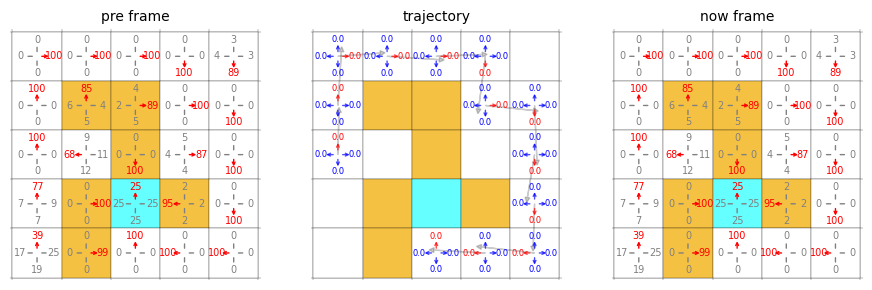

100%|████████████████████████████████████████████████████████████████████| 100000/100000 [02:47<00:00, 596.52it/s]


In [4]:
hyperparameters = {
    'forbiddenAreaScore': -200,  #踩陷阱和碰壁的惩罚
    'hitWallScore': -100,
    'targetAreaScore': 50,     #奖励
    'moveScore': -1,            #移动惩罚
    'action_space': 4,         
    'learning_rate': 0.001,    
    'hidden_dim': 512,
    'gamma': 0.95,              #折扣因子
    'num_episodes': 100000,      #训练轮次，每次训练epsilon -= gamma_minus_each_episodes
    'start_state': 10,
    'exploring_step':40, ##########################
    
    'begin_epsilon':0,
    'final_epsilon':0,
    'gamma_minus_each_episodes':0.00001
}

start_state = hyperparameters['start_state']

# 创建 images 文件夹（如果不存在）
experiment_name = f"Penalty{hyperparameters['forbiddenAreaScore']}_Score{hyperparameters['targetAreaScore']}_State"
output_dir = f"experiments/{experiment_name}(0~24)/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 图片文件路径

img_name = f"{experiment_name}{start_state}"
img_path = os.path.join(output_dir, img_name)
xlsx_path = os.path.join(output_dir, experiment_name+".xlsx")
print(img_path)
train(hyperparameters, img_path)

utils.write_excel(hyperparameters ,img_path+'.png', bias = start_state, xlsx_path=xlsx_path, highlights=['start_state'])


In [ ]:
# episodes_list = list(range(len(return_list)))
# plt.plot(episodes_list, return_list)
# plt.xlabel('Episodes')
# plt.ylabel('Returns')
# plt.title('REINFORCE on {}'.format(env_name))
# plt.show()

# mv_return = rl_utils.moving_average(return_list, 9)
# plt.plot(episodes_list, mv_return)
# plt.xlabel('Episodes')
# plt.ylabel('Returns')
# plt.title('REINFORCE on {}'.format(env_name))
# plt.show()